# Imports

In [3]:
import torch
from pytorch_forecasting.models import TemporalFusionTransformer
import pytorch_lightning as pl
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import gym
from gym import spaces
from pytorch_forecasting import TemporalFusionTransformer
from stable_baselines3 import PPO

# Load models & datas

In [4]:
#tft_model = torch.load('tft_model.pth')
#tft_model.train()  

/var/folders/3c/3vphwslj5cqgtlvx43cxfr1h0000gn/T/ipykernel_58311/4064102655.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True)


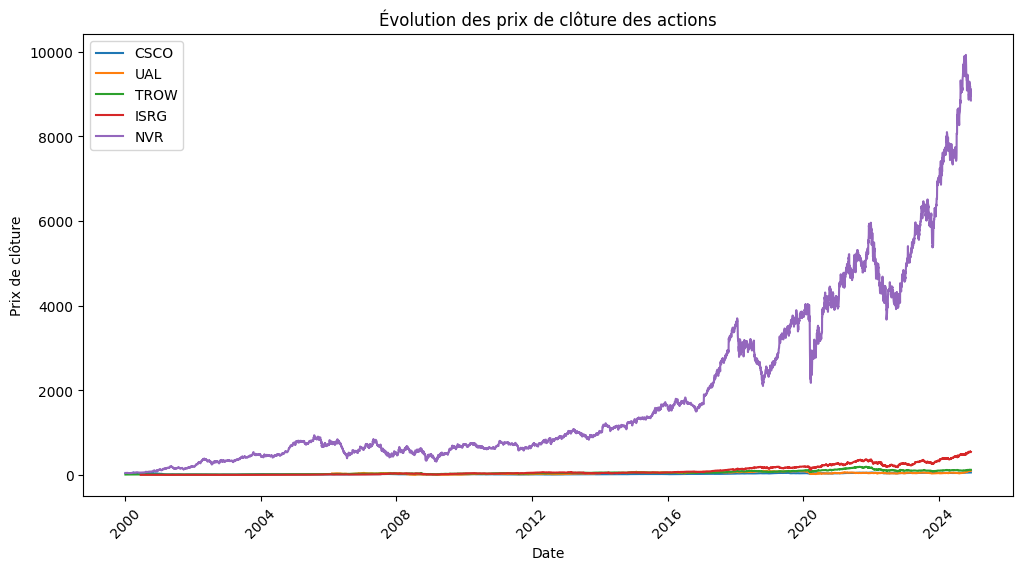

  Unnamed: 0       Date      Close       High        Low       Open    Volume  \
0          0 2000-01-03  35.810463  36.535371  34.319223  36.431813  53076000   
1          1 2000-01-04  33.801411  35.458343  33.718564  34.961263  50805600   
2          2 2000-01-05  33.697857  34.629881  32.227330  33.159354  68524000   
3          3 2000-01-06  33.138645  33.759995  32.682989  33.407897  48242600   
4          4 2000-01-07  35.085533  35.126956  32.931522  32.931522  62260600   

  ticker  SMA        EMA  ...  Daily_Return  Excess_Return  Sharpe_Ratio  \
0   CSCO  NaN  35.810463  ...           NaN            NaN      0.180554   
1   CSCO  NaN  35.619125  ...     -0.056102      -0.056182      0.180554   
2   CSCO  NaN  35.436147  ...     -0.003064      -0.003143      0.180554   
3   CSCO  NaN  35.217337  ...     -0.016595      -0.016674      0.180554   
4   CSCO  NaN  35.204784  ...      0.058750       0.058670      0.180554   

   time_idx  day_of_week  day_of_month  month  year  qua

In [5]:
import os
import pandas as pd
import numpy as np

# Définition du dossier où sont stockés les fichiers extraits
extract_path = "data/stocks"

# Chargement de tous les fichiers CSV dans un DataFrame unique
dfs = []
for file in os.listdir(extract_path):
    if file.endswith(".csv"):
        file_path = os.path.join(extract_path, file)
        ticker = file.replace(".csv", "")  # Suppression de l'extension pour obtenir le ticker
        df = pd.read_csv(file_path, parse_dates=['Date'])  # Charger avec la colonne Date
        
        # Vérification des colonnes essentielles
        required_columns = {"Date", "Close", "High", "Low", "Open", "Volume"}
        if not required_columns.issubset(df.columns):
            print(f"⚠️ {file} ignoré car il manque des colonnes nécessaires")
            continue
        
        # Ajout du ticker comme identifiant
        df['ticker'] = ticker
        
        # Tri des données par date
        df = df.sort_values(by='Date')
        
        # Création de time_idx pour TFT (indice temporel relatif à chaque action)
        df['time_idx'] = np.arange(len(df))
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        
        # Variables temporelles
        df['day_of_week'] = df['Date'].dt.dayofweek
        df['day_of_month'] = df['Date'].dt.day
        df['month'] = df['Date'].dt.month
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter
        
        # Stocker le DataFrame
        dfs.append(df)

# Fusionner toutes les actions dans un seul dataset
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    
    # Afficher un aperçu du dataset préparé
    import matplotlib.pyplot as plt
    
    # Visualiser l'évolution du prix pour quelques actions
    plt.figure(figsize=(12, 6))
    
    for ticker in df_all['ticker'].unique()[:5]:  # Afficher 5 actions max
        subset = df_all[df_all['ticker'] == ticker]
        plt.plot(subset['Date'], subset['Close'], label=ticker)

    plt.xlabel("Date")
    plt.ylabel("Prix de clôture")
    plt.title("Évolution des prix de clôture des actions")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    print(df_all.head())  # Afficher un extrait du DataFrame

else:
    print("❌ Aucun fichier CSV valide trouvé.")


In [12]:
df_all.drop(columns=['Unnamed: 0', 'Adj Close'], inplace=True)

In [17]:
df_all.to_csv('df_all.csv', index=False)

In [8]:
tft_model = torch.load("lightning_logs/version_2/checkpoints/epoch=5-step=26826.ckpt")
print(tft_model.keys()) 

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])


In [13]:
df_all.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ticker', 'SMA',
       'EMA', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'RSI', 'CCI', 'OBV',
       'Daily_Return', 'Excess_Return', 'Sharpe_Ratio', 'time_idx',
       'day_of_week', 'day_of_month', 'month', 'year', 'quarter'],
      dtype='object')

# Premier Test

In [ ]:
max_prediction_length = 1 
max_encoder_length = 30   
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["Close"],
    target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
)

train_dataloader = DataLoader(training, batch_size=64, shuffle=True)


In [ ]:
def compute_sharpe(profit, eps=1e-6, risk_free_rate=0.0):
    excess = profit - risk_free_rate
    mean = torch.mean(excess)
    std = torch.std(excess) + eps
    return mean / std


In [ ]:
optimizer = optim.Adam(tft_model.parameters(), lr=1e-4)
num_epochs = 20  # nombre d'époques de fine-tuning

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        # Le modèle attend généralement que le batch soit un dictionnaire comprenant :
        # "encoder_cont", "decoder_cont", "encoder_target", "decoder_target", etc.
        # Ici, nous utilisons le batch complet tel que fourni par le DataLoader.
        predictions = tft_model(batch)  # prédictions de forme (batch_size, max_prediction_length)
        predicted_price = predictions.squeeze(-1)  # forme : (batch_size,)
        
        # Récupération des prix réels
        # "decoder_target" contient le prix futur réel sur le pas de prédiction
        actual_price = batch["decoder_target"].squeeze(-1)  # (batch_size,)
        # "encoder_target" contient l'historique ; on prend le dernier prix comme prix actuel
        current_price = batch["encoder_target"][:, -1]  # (batch_size,)
        
        # Calcul du rendement réel : (prix futur - prix actuel) / prix actuel
        returns = (actual_price - current_price) / current_price
        
        # Calcul du rendement prévisionnel à partir du modèle
        predicted_return = (predicted_price - current_price) / current_price
        
        # Déduire une action (position) : ici, tanh pour contraindre l’action entre -1 (short) et 1 (long)
        action = torch.tanh(predicted_return)
        
        # Calcul du profit : produit de l'action et du rendement réel
        profit = action * returns
        
        # Calcul du Sharpe Ratio sur le batch
        sharpe = compute_sharpe(profit)
        
        # Pour maximiser le Sharpe, nous minimisons la perte négative du Sharpe
        loss = -sharpe
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


# Second test 

In [22]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import random
import datetime

# Pour l'agent RL avec Stable-Baselines3
from stable_baselines3 import PPO

# --- Définition de l'environnement de trading RL ---
class TradingEnv(gym.Env):
    """
    Environnement de trading simulé.
    
    Observation:
      - Une fenêtre historique de données (issues de df_all) aplatie,
      - suivie d'une valeur correspondant à la variation prédite du prochain 'Close',
      - et de la position actuelle.
    
    Action:
      0 = rester en cash, 1 = position longue, 2 = position courte.
      
    Récompense:
      La récompense finale correspond au Sharpe Ratio des rendements de l'épisode.
    """
    def __init__(self, df, tft_model, window_size=10, initial_cash=10000):
        super(TradingEnv, self).__init__()
        
        # Conserver une copie du DataFrame complet
        self.df = df.copy()
        # Garder uniquement les colonnes numériques pertinentes (en excluant 'Date' et 'ticker')
        self.data = self.df.drop(columns=['Date', 'ticker']).to_numpy()
        self.tft_model = tft_model
        self.window_size = window_size
        self.initial_cash = initial_cash
        
        # Nombre de features après suppression de 'Date' et 'ticker'
        self.n_features = self.data.shape[1]
        # Observation = fenêtre historique aplatie (window_size * n_features) + 2 scalaires (prédiction + position)
        obs_dim = window_size * self.n_features + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        # Espace d'action : 0 = cash, 1 = long, 2 = short
        self.action_space = spaces.Discrete(3)
        
        self.reset()
        
    def reset(self):
        # Commencer l'épisode après avoir constitué une fenêtre initiale
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.position = 0  # 1 = long, -1 = short, 0 = neutre
        self.returns_history = []
        return self._get_obs()
    
    def _get_obs(self):
        # Extraction de la fenêtre historique
        start = self.current_step - self.window_size
        end = self.current_step
        window = self.data[start:end, :]  # forme: (window_size, n_features)
        
        # Supposons que la première colonne correspond à 'Close'
        last_price = window[-1, 0]
        
        # Normalisation de la colonne 'Close' par rapport au dernier prix
        norm_window = window.copy()
        if last_price != 0:
            norm_window[:, 0] = norm_window[:, 0] / last_price - 1.0
        else:
            norm_window[:, 0] = 0.0
        
        # Prédiction du modèle TFT pour le prochain 'Close'
        predicted_change = 0.0
        try:
            forecast = self.tft_model.predict({"price": window[:, 0]})
            predicted_next_price = float(forecast[0])
            if last_price != 0:
                predicted_change = predicted_next_price / last_price - 1.0
            else:
                predicted_change = 0.0
        except Exception as e:
            predicted_change = 0.0
        
        current_pos = float(self.position)
        
        # Aplatir la fenêtre pour obtenir un vecteur 1D
        flat_window = norm_window.flatten().astype(np.float32)
        # Concaténer la prédiction et la position actuelle
        obs = np.concatenate([flat_window, 
                            np.array([predicted_change], dtype=np.float32), 
                            np.array([current_pos], dtype=np.float32)])
        # Remplacer les NaN par 0 (ou une autre valeur) et clipper l'observation si nécessaire
        obs = np.nan_to_num(obs, nan=0.0)
        obs = np.clip(obs, -100, 100)
        return obs
    
    def step(self, action):
        # Utiliser la colonne 'Close' (première colonne) de la ligne actuelle comme prix
        price = self.data[self.current_step, 0]
        prev_position = self.position
        
        # Déterminer la nouvelle position en fonction de l'action
        if action == 0:
            target_position = 0
        elif action == 1:
            target_position = 1
        elif action == 2:
            target_position = -1
        else:
            target_position = self.position
        
        # Mise à jour du cash et de la position selon la transition
        if target_position != self.position:
            if target_position == 1:  # Passage en long
                if self.position == 0:
                    self.cash -= price
                elif self.position == -1:
                    self.cash -= price  # Couverture du short
                    self.cash -= price  # Achat pour long
            elif target_position == -1:  # Passage en short
                if self.position == 0:
                    self.cash += price
                elif self.position == 1:
                    self.cash += price  # Vente de long
                    self.cash += price  # Vente à découvert
            elif target_position == 0:
                if self.position == 1:
                    self.cash += price
                elif self.position == -1:
                    self.cash -= price
            self.position = target_position
        
        # Avancer d'un pas
        self.current_step += 1
        done = False
        reward = 0.0
        info = {}
        
        # Si fin des données, terminer l'épisode
        if self.current_step >= len(self.data):
            done = True
            final_price = price
            if self.position == 1:
                self.cash += final_price
            elif self.position == -1:
                self.cash -= final_price
            self.position = 0
            if len(self.returns_history) > 1 and np.std(self.returns_history) > 1e-8:
                sharpe = float(np.mean(self.returns_history) / (np.std(self.returns_history) + 1e-8))
            else:
                sharpe = 0.0
            reward = sharpe
            info["sharpe"] = sharpe
            return self._get_obs(), reward, done, info
        
        # Calcul du profit entre l'étape actuelle et la suivante
        next_price = self.data[self.current_step, 0]
        current_position = self.position
        profit = current_position * (next_price - price)
        portfolio_value_before = self.cash + prev_position * price
        step_return = 0.0
        if portfolio_value_before > 0:
            step_return = float(profit / portfolio_value_before)
        self.returns_history.append(step_return)
        reward = 0.0  # Récompense instantanée nulle, la récompense finale sera calculée à la fin
        obs = self._get_obs()
        return obs, reward, done, info


env = TradingEnv(df_all, tft_model, window_size=10, initial_cash=10000)

# --- Initialisation de l'agent RL (PPO) ---
agent = PPO("MlpPolicy", env, verbose=1)

# --- Entraînement de l'agent sur l'historique df_all ---
timesteps = 10**6  # Nombre de pas d'entraînement
agent.learn(total_timesteps=timesteps)

# --- Test de la stratégie apprise ---
obs = env.reset()
done = False
cum_reward = 0.0
while not done:
    action, _states = agent.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    cum_reward += reward

if done:
    sharpe_ratio = info.get("sharpe", 0.0)
    print(f"Épisode terminé - Sharpe Ratio obtenu: {sharpe_ratio:.3f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/alexis/Projets/Trading/.venv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 4067 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2286        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010374239 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.709      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00582     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00639    |
|    value_loss           | 0.0513      |
-----------------------------------------
----------------------------------

In [19]:
pip install 'shimmy>=2.0'


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
